In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import glob
import os

In [6]:
trial_names = [
                'r50',
                'r50-256bs', 
                'r50-phylum',
                'r50-pytorch',
                'r50-1gpu', 
                'r50-accum-4gpu', 
                'r50-tl', 
                'r101']


paths=  [
            '/pscratch/sd/a/azaidi/new-dt/new-trials/testing/train/datasets/testing/chunks_W1024_S128/resnet50/C/test02/train.3566570',
            '/pscratch/sd/a/azaidi/new-dt/new-trials/testing/train/datasets/testing/chunks_W1024_S128/resnet50/C/test02/train.3566571',
            '/pscratch/sd/a/azaidi/new-dt/new-trials/testing/train/datasets/testing/chunks_W1024_S128/resnet50/C/test02/train.3566572',
            '/pscratch/sd/a/azaidi/new-dt/new-trials/testing/train/datasets/testing/chunks_W1024_S128/resnet50/C/test02/train.3566573',
            '/pscratch/sd/a/azaidi/new-dt/new-trials/testing/train/datasets/testing/chunks_W1024_S128/resnet50/C/test02/train.3566574',
            '/pscratch/sd/a/azaidi/new-dt/new-trials/testing/train/datasets/testing/chunks_W1024_S128/resnet50/C/test02/train.3566575',
            '/pscratch/sd/a/azaidi/new-dt/new-trials/testing/train/datasets/testing/chunks_W1024_S128/resnet50/C/test02/train.3566576',
            '/pscratch/sd/a/azaidi/new-dt/new-trials/testing/train/datasets/testing/chunks_W1024_S128/resnet101/C/test02/train.3566578']


trial_desc = [
    'res50 + 512bs + species class + deep-taxon dataloader',
    'res50 + 256bs + species class + deep-taxon dataloader',
    'res50 + 512bs + phylum class + deep-taxon dataloader',
    'res50 + 512bs + species class + dt dl + pytorch training loop',
    'res50 + 512bs + species class + dt dl + 1gpu',
    'res50 + 512bs + 4epoch grad accum + species class + dt dl',
    'res50 + 512bs + species class + theoretical limit dataloader',
    'res101 + 512bs + species classification, deep-taxon dataloader'
]

trial_tup = tuple(zip(trial_names, paths))

In [7]:
def df_from_csv(my_csv):
    return pd.read_csv(io.StringIO('\n'.join(my_csv[2:-1])))

def get_report_paths(parent_directory):
    report_paths = glob.glob(parent_directory + '/*-rep')
    return report_paths

Below we'll put together some functions to extract information to ask the question: how much of our total training time is being used up by gpu compute?

In [10]:
folder_path = paths[0]
file_path = get_report_paths(folder_path)[0]

In [11]:
def get_logged_time(folder_path):
    log_file = folder_path + '.log'
    log_total_slist = !grep "Total seconds:*" {log_file}
    return float(log_total_slist[0].split()[-1])

get_logged_time(folder_path)

549.239921

In [12]:
#leads to unwieldy output without grep, couldn't figure out how to only pull int starting lines
full_file = !nsys stats --report=gpukernsum --format csv -q $file_path
#len(full_file)#full_file

nccl = !nsys stats --report=gpukernsum --format csv -q $file_path | grep nccl
#nccl #if want to see nccl activities

#total time is second column - first col is % time
#nccl[0].split(',')[1]

#this should get the total number of seconds for nccl related activities
np.array([x.split(',')[1] for x in nccl], dtype=float).sum() / 1e9

6.759747951

In [13]:
def get_nccl_sum(file_path):
    nccl_activities = !nsys stats --report=gpukernsum --format csv -q {file_path} | grep nccl
    total = np.array([x.split(',')[1] for x in nccl_activities], dtype=float).sum() / 1e9
    return total

#hardcoded in 100 of the activities -- played around and not much higher afte 
def get_total_kern(file_path):
    tot_activities = !nsys stats --report=gpukernsum --format csv -q {file_path}
    tot_activities = tot_activities[3:50]
    total = np.array([x.split(',')[1] for x in tot_activities], dtype=float).sum() / 1e9
    return total



In [14]:
get_total_kern(file_path), get_nccl_sum(file_path)

(105.733322915, 6.759747951)

In [15]:
def get_kern_time(parent_dir):
    report_paths = get_report_paths(parent_dir)
    file_path = report_paths[0]
    nccl_time = get_nccl_sum(file_path)
    total_time = get_total_kern(file_path)
    return total_time, nccl_time

In [16]:
get_kern_time(paths[0])

(105.733322915, 6.759747951)

In [17]:
def get_kern_dfs(trial_tuple):
    nccl_times, kern_times, trial_names, logged_times = [], [], [], []
    for trial_name, folder_path in trial_tuple:
        log_time = get_logged_time(folder_path)
        kern_time, nccl_time = get_kern_time(folder_path)
        trial_names.append(trial_name)
        nccl_times.append(nccl_time)
        kern_times.append(kern_time)
        logged_times.append(log_time)
    df = pd.DataFrame(zip(kern_times, nccl_times, logged_times), columns=['kern_time', 'nccl_time', 'logged_time'], index=trial_names)
    return df

In [18]:
#get_kern_dfs(trial_tuple[:2])

In [19]:
df = get_kern_dfs(trial_tup)
df

,kern_time,nccl_time,logged_time
r50,105.733323,6.759748,549.239921
r50-256bs,562.206567,447.623558,694.814695
r50-phylum,412.944029,334.025393,535.758853
r50-pytorch,162.171962,5.562496,679.788115
r50-1gpu,380.433915,0.000000,1114.814917
r50-accum-4gpu,422.715904,338.533442,520.698596
r50-tl,85.088445,3.880080,130.282719
r101,496.882544,329.549190,630.082665


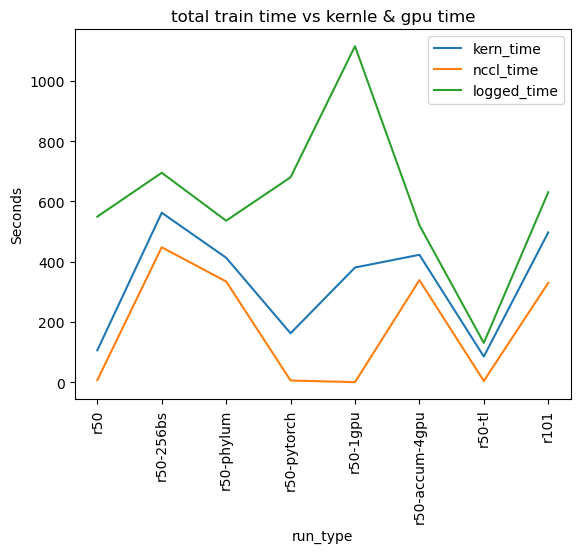

In [20]:
plt.title('total train time vs kernle & gpu time')
plt.xlabel('run_type')
plt.ylabel('Seconds')
plt.plot(df)
plt.legend(df.columns)
plt.xticks(rotation=90);

In [21]:
df['description'] = trial_desc
df.to_csv('train_vs_gpu_time.csv', index=False)

In [22]:
df

,kern_time,nccl_time,logged_time,description
r50,105.733323,6.759748,549.239921,res50 + 512bs + species class + deep-taxon dat...
r50-256bs,562.206567,447.623558,694.814695,res50 + 256bs + species class + deep-taxon dat...
r50-phylum,412.944029,334.025393,535.758853,res50 + 512bs + phylum class + deep-taxon data...
r50-pytorch,162.171962,5.562496,679.788115,res50 + 512bs + species class + dt dl + pytorc...
r50-1gpu,380.433915,0.000000,1114.814917,res50 + 512bs + species class + dt dl + 1gpu
r50-accum-4gpu,422.715904,338.533442,520.698596,res50 + 512bs + 4epoch grad accum + species cl...
r50-tl,85.088445,3.880080,130.282719,res50 + 512bs + species class + theoretical li...
r101,496.882544,329.549190,630.082665,"res101 + 512bs + species classification, deep-..."


In [28]:
#extract relevant information for gpu memory and time and save them into their own respective csv files
def get_nsys_reports(trial_name, parent_directory, folder_destination='artifacts/'):
    report_paths = glob.glob(parent_directory + '/*-rep')
    time_holder, size_holder = [], []
    for path in report_paths:
        time_csv = !nsys stats --report=gpumemtimesum --format csv -q $path
        size_csv = !nsys stats --report=gpumemsizesum --format csv -q $path
        time_holder.append(df_from_csv(time_csv))
        size_holder.append(df_from_csv(size_csv))
    time_df = pd.concat(time_holder, axis=0, ignore_index=True)
    size_df = pd.concat(size_holder, axis=0, ignore_index=True)
    time_df.to_csv(folder_destination + trial_name +'-time.csv', index=False)
    size_df.to_csv(folder_destination + trial_name +'-size.csv', index=False)
    return time_df, size_df

In [35]:
def get_run_dfs(run_type, parent_dir='artifacts/'):
    time_df = pd.read_csv(parent_dir + run_type + '-time.csv')
    size_df = pd.read_csv(parent_dir + run_type + '-size.csv')
    time_df['run_type'] = run_type
    size_df['run_type'] = run_type
    num_gpus = len(time_df)
    time_df['rank'] = np.arange(num_gpus) // 4
    size_df['rank'] = np.arange(num_gpus) // 4
    return time_df, size_df

def get_dfs(trial_names):
    size_dfs, time_dfs = [], []
    for run_type in trial_names:
        time_df, size_df = get_run_dfs(run_type)
        time_dfs.append(time_df)
        size_dfs.append(size_df)
    size_df = pd.concat(size_dfs)
    time_df = pd.concat(time_dfs)
    return size_df, time_df

In [36]:
for name, path in trial_tup:
    _, _ = get_nsys_reports(name, path)

In [37]:
size_dfs, time_dfs = get_dfs(trial_names)
size_dfs.shape, time_dfs.shape

((116, 10), (116, 11))